# Reconhecimento de vegetais usando ResNet50 e ImageDataGenerator

O projeto envolve o reconhecimento de vegetais atraves de um modelo de resnet auxiliado por um ImageDataGenerator para aumento de dados.

Esse é um projeto voltado para ensinar um pouco das ferramentas usadas em classificação de imagens, mas ele tem usos na vida real, podendo ser usado para o reconhecimento de vegetais em caixas automatizados de supermercado.

## Carregar os dados

O conjunto de dados usados veio do kagglehub, sendo um dataset usado na pesquisa de ahmed et al.

https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study

Para baixar os dados voce usa o codigo abaixo

In [1]:
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path) """

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")\n\nprint("Path to dataset files:", path) '

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import os

## EDA

Essa seria a fase onde demonstramos a distribuição das classes, algo essencial em problemas reais de empresa, mas como esse dataset esta organizado e distribuido uniformemente entre todas as classes, não é necessario.

Deixarei o codigo comentado abaixo como exemplo de como fariamos isso no caso de usarmos um ImageDataGenerator dependente do flow_from_dataframe, usando um dataframe pandas como base para carregar as imagens, mas bibliotecas como a pathlib, que nos permite acessar arquivos do computador pelo python, permitem a criação de dataframes e eventual EDA mesmo sem o CSV pre-pronto

In [3]:
""" age=labels['age'].sort_values(ascending=True)
plt.xlabel('age_range')
plt.ylabel('number of people')
age.hist(bins=20) """

" age=labels['age'].sort_values(ascending=True)\nplt.xlabel('age_range')\nplt.ylabel('number of people')\nage.hist(bins=20) "

### Exemplos

Mostrando exemplos das imagens nos datasets.

Cada uma delas é 224 por 224 e tem uma classe associada ao tipo do vegetal na foto, com um total de 15 classes.

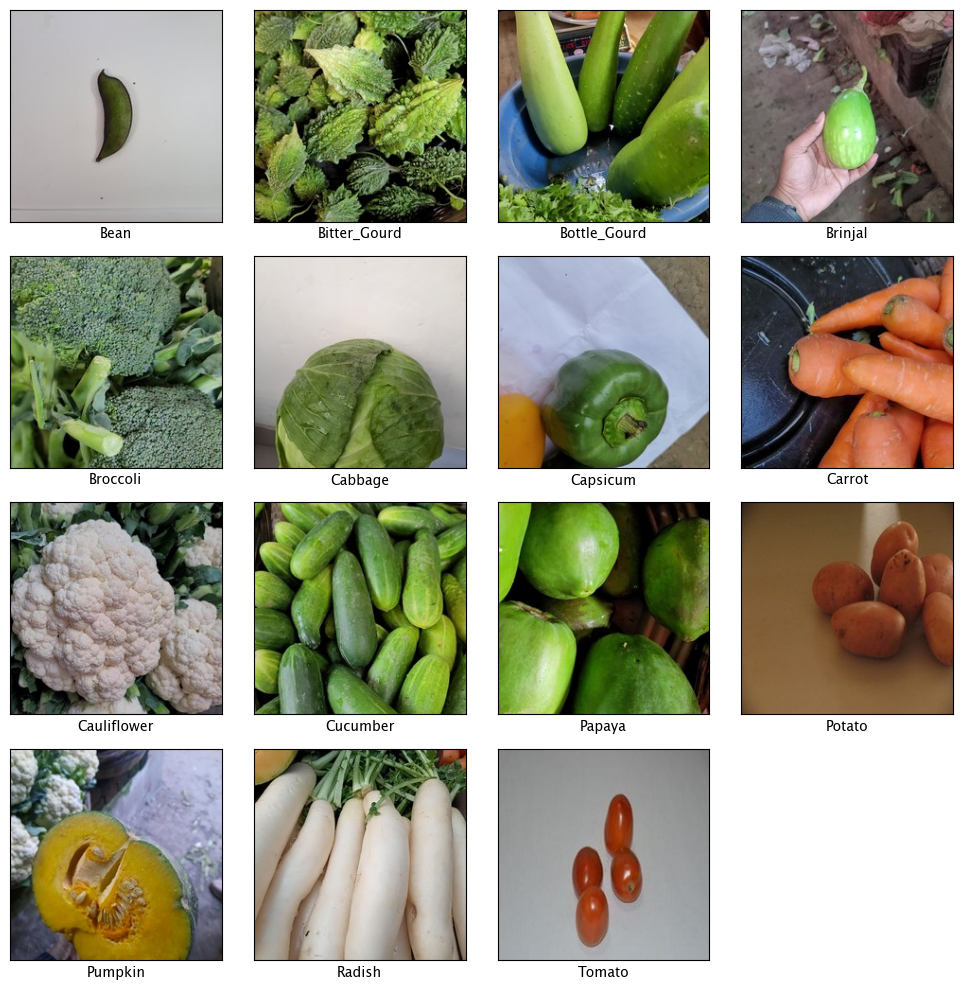

In [4]:
fig = plt.figure(figsize=(10,10))
class_name=['Bean','Bitter_Gourd','Bottle_Gourd','Brinjal','Broccoli','Cabbage','Capsicum','Carrot','Cauliflower','Cucumber','Papaya','Potato','Pumpkin','Radish','Tomato']
image_name=['0026.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg','0001.jpg']
for x in range(0,15):
    image = Image.open('../data/vegetable-image-dataset/versions/1/Vegetable Images/train/'+class_name[x]+'/'+image_name[x])
    fig.add_subplot(4, 4, x+1)
    plt.imshow(np.array(image)) 
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.xlabel(class_name[x])

## Modelagem sem aumento de dados

Alem de importar as bibliotecas necessarias para a modelagem, devemos garantir que os resultados do modelo sejam reproduziveis, ou seja, deterministicos. 

Isso é feito usando as funções abaixo, que colocam uma seed especifica para cada biblioteca e configuram uma seed para o paralelismo usado pelo tensorflow.

Essas funções não são necessarias para o uso de bibliotecas como o scikit, onde podemos colocar a seed nos parametros do modelo, e tem algumas consequencias, como deixar o treinamento mais lento ja que o modelo se tornou deterministico.

Isso não é o suficiente para poder replicar o modelo exato em cada iteração do mac, ja que usamos a GPU e possivelmente a NPU nesse caso, mas em computadores windows sem gpu ou sem a flag habilitada deve ser o suficiente.

In [5]:
import pandas as pd
import tensorflow as tf
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=12345)

In [6]:
def load_image_flow(path,target_size):
    
    datagen = ImageDataGenerator(rescale = 1./255)
    gen_flow = datagen.flow_from_directory(
        directory=path,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=12345,
    )


    return gen_flow

Acima e abaixo usamos um ImageDataGenerator, permitindo com que as fotos sejam carregadas em batches de acordo com o tamanho escolhido. Nos dividimos cada pixel da imagem por 255 para os valores ficarem entre 1 e 0.

Carregar uma foto é coloca-la na memoria RAM, e no caso de um modelo baseado em ResNet, que precisa de pelo menos umas ~5 mil imagens para rodar direito, é impossivel carregar todas as fotos de uma vez só sem estorrar a RAM de uma maquina normal (Se você tiver uma maquina com RAM o suficiente para isso você bem que poderia me contratar para a sua empresa).

No caso do exemplo acima usamos o flow_from_directory, carregando diretamente do diretorio sem o uso de uma dataframe pandas ou CSV auxiliar, mas o exemplo abaixo é uma versão que usa do auxilio.

O diretorio é o caminho para o diretorio contendo as imagens, se lembrando que para o gerador funcionar as imagens devem estar em subdiretorios com o nome da sua classe.

Target size é o tamanho da foto e muda de projeto para projeto, quanto maior a imagem mais processamento é necessario, então mais lento fica.

O class mode muda de acordo com a tarefa que voce esta fazendo, usamos categorico ja que este é um problema de classificação, mas em seu projeto voce precisaria consultar a documentação e mudar para a classe certa.

Shuffle embaralha as fotos para evitar que o modelo dependa da ordem das fotos para uma previsão.

Como adicional, podemos colocar o validation_split, quantas imagens vão para treino ou teste e falar se o subset é 'training', treinamento, ou 'validation', para teste ou validação, como esta abaixo. Não é necessario neste projeto ja que as o treino, teste e validação ja foi pre-separado.

In [7]:
""" def load_train(path):
    
    datagen = ImageDataGenerator(validation_split=0.25,rescale = 1./255)
    train_df = pd.read_csv(path+"age_detection.csv")
    train_df=train_df[train_df['split'].values=='train']
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path,
        x_col="file", y_col="age",
        target_size=(960,1280),
        batch_size=16,
        class_mode='categorical',
        subset='training',
        seed=12345,
    )


    return train_gen_flow """

' def load_train(path):\n    \n    datagen = ImageDataGenerator(validation_split=0.25,rescale = 1./255)\n    train_df = pd.read_csv(path+"age_detection.csv")\n    train_df=train_df[train_df[\'split\'].values==\'train\']\n    train_gen_flow = datagen.flow_from_dataframe(\n        dataframe=train_df,\n        directory=path,\n        x_col="file", y_col="age",\n        target_size=(960,1280),\n        batch_size=16,\n        class_mode=\'categorical\',\n        subset=\'training\',\n        seed=12345,\n    )\n\n\n    return train_gen_flow '

In [8]:
train_gen_flow=load_image_flow('../data/vegetable-image-dataset/versions/1/Vegetable Images/train/',target_size=(224,224))

Found 15000 images belonging to 15 classes.


In [9]:
test_gen_flow=load_image_flow('../data/vegetable-image-dataset/versions/1/Vegetable Images/test/',target_size=(224,224))

Found 3000 images belonging to 15 classes.


In [10]:
def create_model(input_shape):
    
    
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(15, activation='softmax')) 
    
    optimizer= Adam()
    
    model.compile(
        loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']
    )


    return model

Usamos o ResNet, modelo pre treinado especializado em classificação de imagens, como o backbone do modelo, ou seja, modificamos e adicionamos novas camadas finais para a tarefa especifica que queremos executar.

Nesse caso, a camada de softmax é usada, com o numero de classes como o numero de neuros por ser um problema de classificação. Mas a camada sigmoid seria mais apropriada em um modelo de regressão.

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    optimizer= Adam()
    model.compile(
        loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy','Precision','Recall']
    )
    model.fit(
    train_data,
    validation_data=test_data,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=2)

    return model

In [12]:
model=create_model(input_shape=(224,224,3))
model_alt=create_model(input_shape=(224,224,3))

2025-04-21 16:05:33.488565: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-21 16:05:33.488600: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-21 16:05:33.488607: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-21 16:05:33.488644: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-21 16:05:33.488657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Usamos O shape com (*,*,3) pois a imagem tem 3 canais de cores.

In [13]:
model=train_model(model,train_gen_flow,test_gen_flow,epochs=8)

Epoch 1/8


2025-04-21 16:05:40.012283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-21 16:05:40.723419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


469/469 - 121s - loss: 0.3969 - accuracy: 0.9003 - precision: 0.9379 - recall: 0.8627 - val_loss: 7.1726 - val_accuracy: 0.0667 - val_precision: 0.0667 - val_recall: 0.0667 - 121s/epoch - 257ms/step
Epoch 2/8
469/469 - 109s - loss: 0.1066 - accuracy: 0.9689 - precision: 0.9747 - recall: 0.9631 - val_loss: 3.4192 - val_accuracy: 0.5003 - val_precision: 0.5141 - val_recall: 0.4733 - 109s/epoch - 231ms/step
Epoch 3/8
469/469 - 109s - loss: 0.0416 - accuracy: 0.9885 - precision: 0.9896 - recall: 0.9866 - val_loss: 10.7252 - val_accuracy: 0.2973 - val_precision: 0.2973 - val_recall: 0.2907 - 109s/epoch - 233ms/step
Epoch 4/8
469/469 - 115s - loss: 0.0546 - accuracy: 0.9836 - precision: 0.9856 - recall: 0.9819 - val_loss: 1.3937 - val_accuracy: 0.7233 - val_precision: 0.7488 - val_recall: 0.7143 - 115s/epoch - 245ms/step
Epoch 5/8
469/469 - 118s - loss: 0.0400 - accuracy: 0.9888 - precision: 0.9905 - recall: 0.9873 - val_loss: 0.0739 - val_accuracy: 0.9747 - val_precision: 0.9766 - val_recal

O modelo começa a perder accuracy depois da 6 epoch, indicando que ele esta sofrendo com overfiting. 

Para testar essa hipotese irei treinar um modelo alternativo com 6 epochs e comparar ambos nos dados de validação

In [14]:
model_alt=train_model(model_alt,train_gen_flow,test_gen_flow,epochs=6)

Epoch 1/6


2025-04-21 16:20:49.982857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


469/469 - 121s - loss: 0.3485 - accuracy: 0.9063 - precision: 0.9416 - recall: 0.8767 - val_loss: 3.0559 - val_accuracy: 0.0567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 121s/epoch - 258ms/step
Epoch 2/6
469/469 - 109s - loss: 0.0842 - accuracy: 0.9750 - precision: 0.9783 - recall: 0.9707 - val_loss: 2.0106 - val_accuracy: 0.4707 - val_precision: 0.5211 - val_recall: 0.4197 - 109s/epoch - 233ms/step
Epoch 3/6
469/469 - 110s - loss: 0.0464 - accuracy: 0.9857 - precision: 0.9881 - recall: 0.9836 - val_loss: 0.1002 - val_accuracy: 0.9673 - val_precision: 0.9727 - val_recall: 0.9623 - 110s/epoch - 235ms/step
Epoch 4/6
469/469 - 110s - loss: 0.0379 - accuracy: 0.9880 - precision: 0.9896 - recall: 0.9863 - val_loss: 0.6149 - val_accuracy: 0.8567 - val_precision: 0.8673 - val_recall: 0.8450 - 110s/epoch - 234ms/step
Epoch 5/6
469/469 - 110s - loss: 0.0888 - accuracy: 0.9730 - precision: 0.9766 - recall: 0.9699 - val_loss: 0.2912 - val_accuracy: 0.9057 - val_precision: 0.9245 - va

O treinamento poderia ser mais rapido se eu usasse as funções otimizadas para mac, mas como é raro o uso de macs por estudantes ou em treinamentos de IA, deixei em um formato generalista.

## Modelagem com aumento de dados

Alem do ImageDataGenerator permitir voce carregar imagens em batches, não sobrecarregando a RAM, ele tambem permite voce aumentar artificialmente com transformações nas imagens originais, como gira-las.

O uso ou não desse aumento depende do contexo, se voce quer classificar a direção que algo aponta não faz sentido voce girar a imagem e deixar o mesmo label, ja que isso seria erroneo, ja em dados que não e necessario se preocupar com orientação, como as fotos de vegetais, a muito a se ganhar,  como o modelo aprender a reconhecer uma classe sem se importar com sua orientação e ter dados extras.

In [15]:
def load_train_augment_image_flow(path,target_size):
    
    datagen = ImageDataGenerator(rescale = 1./255,horizontal_flip=True,vertical_flip=True)
    gen_flow = datagen.flow_from_directory(
        directory=path,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',
        shuffle=True,
        seed=12345,
    )


    return gen_flow

In [16]:
train_augment_gen_flow=load_train_augment_image_flow('../data/vegetable-image-dataset/versions/1/Vegetable Images/train/',target_size=(224,224))

Found 15000 images belonging to 15 classes.


In [17]:
augment_model=create_model(input_shape=(224,224,3))
augment_model_alt=create_model(input_shape=(224,224,3))

In [18]:
augment_model=train_model(augment_model,train_augment_gen_flow,test_gen_flow,epochs=8)

Epoch 1/8


2025-04-21 16:32:04.844541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


469/469 - 125s - loss: 0.3745 - accuracy: 0.8997 - precision: 0.9340 - recall: 0.8658 - val_loss: 19.2239 - val_accuracy: 0.0667 - val_precision: 0.0667 - val_recall: 0.0667 - 125s/epoch - 266ms/step
Epoch 2/8
469/469 - 114s - loss: 0.1071 - accuracy: 0.9692 - precision: 0.9756 - recall: 0.9635 - val_loss: 1.8535 - val_accuracy: 0.5633 - val_precision: 0.5921 - val_recall: 0.5357 - 114s/epoch - 243ms/step
Epoch 3/8
469/469 - 115s - loss: 0.0640 - accuracy: 0.9799 - precision: 0.9826 - recall: 0.9777 - val_loss: 0.1558 - val_accuracy: 0.9507 - val_precision: 0.9573 - val_recall: 0.9420 - 115s/epoch - 246ms/step
Epoch 4/8
469/469 - 115s - loss: 0.0714 - accuracy: 0.9776 - precision: 0.9810 - recall: 0.9753 - val_loss: 2.9971 - val_accuracy: 0.5827 - val_precision: 0.5926 - val_recall: 0.5793 - 115s/epoch - 246ms/step
Epoch 5/8
469/469 - 114s - loss: 0.0528 - accuracy: 0.9844 - precision: 0.9863 - recall: 0.9823 - val_loss: 0.1473 - val_accuracy: 0.9627 - val_precision: 0.9648 - val_recal

O modelo começa a perder accuracy depois da 5 epoch, indicando que ele esta sofrendo com overfiting. 

Para testar essa hipotese irei treinar um modelo alternativo com 5 epochs e comparar ambos nos dados de validação

In [19]:
augment_model_alt=train_model(augment_model_alt,train_augment_gen_flow,test_gen_flow,epochs=5)

Epoch 1/5


2025-04-21 16:47:36.936962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


469/469 - 127s - loss: 0.4058 - accuracy: 0.8936 - precision: 0.9279 - recall: 0.8583 - val_loss: 21.4419 - val_accuracy: 0.0517 - val_precision: 0.0517 - val_recall: 0.0517 - 127s/epoch - 271ms/step
Epoch 2/5
469/469 - 115s - loss: 0.0815 - accuracy: 0.9756 - precision: 0.9804 - recall: 0.9705 - val_loss: 1.7247 - val_accuracy: 0.5563 - val_precision: 0.5936 - val_recall: 0.5230 - 115s/epoch - 246ms/step
Epoch 3/5
469/469 - 115s - loss: 0.0991 - accuracy: 0.9707 - precision: 0.9756 - recall: 0.9669 - val_loss: 0.2172 - val_accuracy: 0.9357 - val_precision: 0.9430 - val_recall: 0.9313 - 115s/epoch - 246ms/step
Epoch 4/5
469/469 - 114s - loss: 0.0636 - accuracy: 0.9805 - precision: 0.9834 - recall: 0.9779 - val_loss: 0.3466 - val_accuracy: 0.8900 - val_precision: 0.9045 - val_recall: 0.8743 - 114s/epoch - 243ms/step
Epoch 5/5
469/469 - 115s - loss: 0.0444 - accuracy: 0.9864 - precision: 0.9886 - recall: 0.9847 - val_loss: 1.2773 - val_accuracy: 0.7883 - val_precision: 0.8008 - val_recal

Como o modelo teve 4 vezes a quantidade de dados de treinamento - girar a imagem para esquerda,direita ou cabeça para baixo - o treinamento precisou de menos epochs para convergir em um valor, alcançado 96%-98% de accuracy no teste em 5 epochs, ao invez das 6 necessarias no antigo.

Poderiamos otimizar ainda mais os resultados de todos os modelos ao modificar a learning_rate, taxa de treinamento, do otimizador adam, possivelmente deixando o modelo não dar overshoot de certos detalhes. 

O uso de camadas como o dropout, que randomicamente desativa certos neuronios nas camadas, poderia fazer o modelo aprender a generalizar o seu pensamento em diversos neuronios ao invez de focar em um só caminho, possivelmente melhorando a compreensão do modelo. Mas claro, todas essas e outras propostas fazem o treinamento demorar mais tempo, e esse notebook ja demora quase 2 horas para rodar, então deixarei isso para um projeto especializado extra.

## Comparando modelos contra a validação

In [20]:
val_gen_flow=load_image_flow('../data/vegetable-image-dataset/versions/1/Vegetable Images/validation/',target_size=(224,224))

Found 3000 images belonging to 15 classes.


Usamos a função .evaluate para avaliar a perfomance de um modelo em certos dados.

Embora o .predict volte uma accuracia e a previsão do modelo para o dataset `não o use sozinho`, ele não segue as mesmas metricas especificadas durante o compile do modelo

### Modelo sem rotação de dados com 8 epochs - Overfit

In [21]:
model.evaluate(val_gen_flow)

94/94 [==============================] - 8s 85ms/step - loss: 0.2733 - accuracy: 0.9097 - precision: 0.9200 - recall: 0.9007


[0.2733033299446106, 0.9096666574478149, 0.919986367225647, 0.9006666541099548]

### Modelo sem rotação de dados com 6 epochs 

In [22]:
model_alt.evaluate(val_gen_flow)

94/94 [==============================] - 8s 80ms/step - loss: 0.0818 - accuracy: 0.9760 - precision: 0.9796 - recall: 0.9757


[0.0818120613694191,
 0.9760000109672546,
 0.9795849919319153,
 0.9756666421890259]

### Modelo com rotação de dados com 8 epochs - Overfit

In [23]:
augment_model.evaluate(val_gen_flow)

94/94 [==============================] - 8s 87ms/step - loss: 1.7960 - accuracy: 0.6637 - precision: 0.6824 - recall: 0.6497


[1.7959765195846558,
 0.6636666655540466,
 0.6824229955673218,
 0.6496666669845581]

### Modelo com rotação de dados com 5 epochs 

In [24]:
augment_model_alt.evaluate(val_gen_flow)

94/94 [==============================] - 8s 87ms/step - loss: 1.2539 - accuracy: 0.7940 - precision: 0.8065 - recall: 0.7820


[1.2539085149765015,
 0.7940000295639038,
 0.8064627051353455,
 0.7820000052452087]

## Conclusões

O modelo treinado sem rotação de dados em 6 epochs foi o melhor, atingindo 97% de accuracy na validação

Mesmo usando o ResNet com um topo modificado simples ainda temos uma alta accuracy no modelo, mas é necessario mais modificações e melhorias para chegar ao estado da arte, 99%+.